# Tweet Sentiment Classification with Fine-Tuned GPT-2
*A transformer-based solution for decoding mood on social media*

## Import Libraries

Libraries required for data processing and modeling are imported.

This project runs in Google Colab to make use of the free GPU support. Start by mounting Google Drive to access the project files. If this is your first time running the project, clone the repository. Otherwise, pull the latest changes to stay up to date. Once that’s done, run the setup script to install any dependencies and make sure the environment is ready to go.

In [1]:
# Mount Drive on colab manually
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# If the repo doesn't exist in Google Drive, clone it
# !git clone https://github.com/herrerovir/gpt2-tweet-sentiment

# If the repo does exist:
%cd /content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment
!git pull

/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment
Updating 04fcd86..1d05e96
error: Your local changes to the following files would be overwritten by merge:
	notebooks/gpt2-finetune-tweet-sentiment.ipynb
Please commit your changes or stash them before you merge.
error: The following untracked working tree files would be overwritten by merge:
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/dataset_dict.json
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/test/data-00000-of-00001.arrow
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/test/dataset_info.json
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/test/state.json
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/train/data-00000-of-00001.arrow
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/train/dataset_info.json
	data/processed/HF-dataset-tweet-sentiment-extraction-cleaned/train/state.json
Please move or remove them before you merge.
Aborting

In [3]:
# Import config file
import config
config.setup(subdir = "notebooks")
from config import *

Working directory set to: /content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/notebooks


In [4]:
# Install dependencies
!pip install evaluate

# Utilities
import re
from collections import Counter
import numpy as np
import pandas as pd
import torch

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Hugging Face datasets and transformers
from datasets import load_from_disk, DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    GPT2Config,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
    set_seed
)

# Evaluation tools
import evaluate
from evaluate import load

# Set random seed for reproducibility
set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


## Data Loading

This step loads a preprocessed dataset using Hugging Face’s load_from_disk method. The dataset is stored locally and includes different splits, such as training and validation, organized in a DatasetDict. Once loaded, it can be used directly for model training, evaluation, or inspection.

In [5]:
# Load preprocessed Hugging Face dataset
dataset: DatasetDict = load_from_disk(RAW_DIR / "HF-dataset-tweet-sentiment-extraction")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3534
    })
})

## Data Cleaning

This step removes nulls, duplicates, URLs, mentions, and extra spaces to reduce noise and improve model performance. It also checks label distribution to ensure classes are balanced before training.

In [6]:
# Show first entries of the dataset
print("First 5 entries from the training data:")
for i in range(5):
    print(f"\n{i+1}. {dataset['train'][i]['text']}")

First 5 entries from the training data:

1.  I`d have responded, if I were going

2.  Sooo SAD I will miss you here in San Diego!!!

3. my boss is bullying me...

4.  what interview! leave me alone

5.  Sons of ****, why couldn`t they put them on the releases we already bought


### Dataset split and sizes

Check the number of samples in each split to confirm the dataset is structured correctly and ready for use.

In [7]:
print("Dataset splits and sizes:")
for split in dataset:
    print(f"- {split}: {len(dataset[split])} samples")

Dataset splits and sizes:
- train: 27481 samples
- test: 3534 samples


### Null Values

Identify and handle missing data to prevent errors during training and ensure model reliability. Cleaning null values helps maintain data quality.

In [8]:
print("Null values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    empty_count = sum(1 for x in texts if x is None or (isinstance(x, str) and x.strip() == ""))
    print(f"- {split}: {empty_count} null values")


Null values in the dataset:
- train: 1 null values
- test: 0 null values


In [9]:
def is_valid(example):
    """
    Checks whether a text example is valid for further processing.

    An example is considered valid if:
    - The 'text' field is not None.
    - The 'text' field is not an empty string or whitespace-only.

    Parameters:
        example (dict): A single data sample, expected to have a 'text' key.

    Returns:
        bool: True if the example has a valid, non-empty 'text' field; False otherwise.
    """
    return example["text"] is not None and example["text"].strip() != ""

dataset = dataset.filter(is_valid)

In [10]:
print("Dataset splits sizes after removing null values:")
for split in dataset:
    print(f"- {split}: {len(dataset[split])} samples")

Dataset splits sizes after removing null values:
- train: 27480 samples
- test: 3534 samples


### Duplicate Values

Detect and remove duplicate entries to avoid bias and ensure the model trains on unique data points.

In [11]:
print("Duplicate values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    dupes = len(texts) - len(set(texts))
    print(f"- {split}: {dupes} duplicates")

Duplicate values in the dataset:
- train: 0 duplicates
- test: 0 duplicates


### Remove URLs, Mentions and White Spaces

Clean the text by removing URLs, user mentions, and extra white spaces to reduce noise and improve model focus on meaningful content.

In [12]:
def clean_tweet(text):
    """
    Cleans a tweet for sentiment classification:

    Steps performed:
    - Removes URLs (e.g., http://..., https://..., www...)
    - Removes user mentions (e.g., @username)
    - Removes extra whitespace (multiple spaces, leading/trailing spaces)

    Parameters:
        text (str): The tweet text to clean. Can be None.

    Returns:
        str: The cleaned tweet text. If input is None, returns an empty string.
    """
    if text is None:
        return ""

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove mentions
    text = re.sub(r"@\w+", "", text)

    # Remove extra spaces and strip leading/trailing whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [13]:
def clean_example(example):
    example["text"] = clean_tweet(example["text"])
    return example

dataset = dataset.map(clean_example)

Check for duplicates again after cleaning to ensure no redundant data remains that could affect model performance.

In [14]:
print("Duplicate values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    dupes = len(texts) - len(set(texts))
    print(f"- {split}: {dupes} duplicates")

Duplicate values in the dataset:
- train: 45 duplicates
- test: 1 duplicates


In [15]:
for split in dataset:
    # Convert to pandas DataFrame
    df = dataset[split].to_pandas()
    # Drop duplicates
    df = df.drop_duplicates(subset = ["text"])
    # Convert back to Dataset
    dataset[split] = dataset[split].from_pandas(df)

### Label Distribution

Review the balance of labels to identify any class imbalances that could impact model training and evaluation. The dataset includes three labels: 0 for negative, 1 for neutral, and 2 for positive.

In [16]:
print("Dataset Label distribution:")
for split in dataset:
    labels = dataset[split]["label"]
    counts = Counter(labels)
    total = len(labels)

    print(f"\n{split.title()} Set:")
    for label, count in sorted(counts.items()):
        print(f"  Label {label}: {count} ({count/total*100:.2f}%)")

Dataset Label distribution:

Train Set:
  Label 0: 7773 (28.33%)
  Label 1: 11103 (40.47%)
  Label 2: 8559 (31.20%)

Test Set:
  Label 0: 1000 (28.30%)
  Label 1: 1430 (40.48%)
  Label 2: 1103 (31.22%)


The dataset has three labels: 0 (negative), 1 (neutral), and 2 (positive). The distribution across train and test sets is fairly balanced, with each class representing roughly 28% to 40% of the data. This balance reduces the risk of bias during model training.

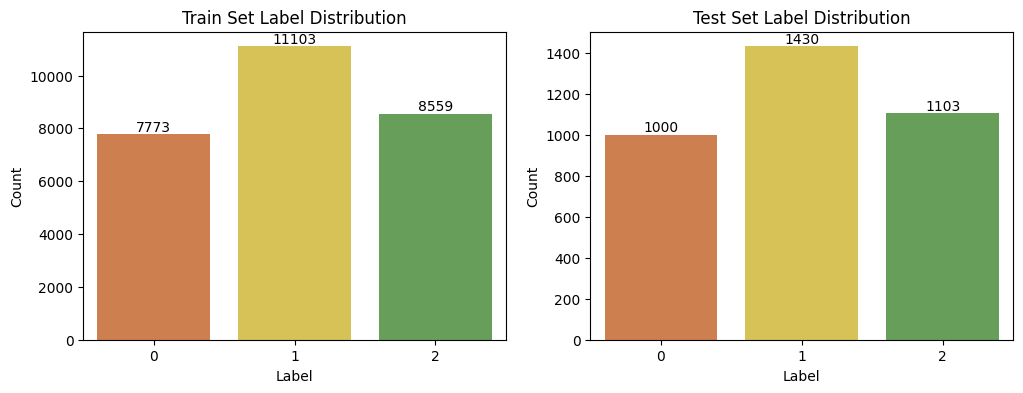

In [17]:
label_colors = {"0": "#e27a3b", "1": "#edd041", "2": "#60aa4f"}

# Plot label distribution for each split
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

for idx, split in enumerate(dataset):
    # Convert the split to a pandas DataFrame
    df = dataset[split].to_pandas()
    # Calculate label distribution
    label_counts = df["label"].value_counts().sort_index()

    # Prepare data for plotting
    plot_df = pd.DataFrame({
        "label": label_counts.index.astype(str),
        "count": label_counts.values
    })

    # Plot using hue and custom palette
    ax = axes[idx]
    sns.barplot(data = plot_df, x = "label", y = "count", hue = "label", palette = label_colors, ax = axes[idx], legend = False)

    # Add value labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2, height), ha = "center", va = "bottom", fontsize = 10)

    axes[idx].set_title(f"{split.title()} Set Label Distribution")
    axes[idx].set_xlabel("Label")
    axes[idx].set_ylabel("Count")

In [18]:
# Save the cleaned dataset
dataset.save_to_disk(PROCESSED_DIR / "HF-dataset-tweet-sentiment-extraction-cleaned")

Saving the dataset (0/1 shards):   0%|          | 0/27435 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3533 [00:00<?, ? examples/s]

## Tokenization

The GPT-2 tokenizer is initialized to convert text into tokens the model can process. Since GPT-2 doesn’t have a pad token, the end-of-sequence token is used as a substitute. The dataset is tokenized with truncation enabled to limit sequence length, but padding is not added here because batching with padding is handled later during training for efficiency.

Next, the label column is renamed to labels to match what the transformers library expects. Finally, the dataset format is set to PyTorch tensors, keeping only the necessary columns: input_ids, attention_mask, and labels.

In [19]:
# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token # workaround since GPT-2 has no pad token

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation = True) # only truncation, no padding

tokenized_dataset = dataset.map(tokenize_function, batched = True)

# Retain the label but first rename the column, transformers expect a column named labels
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Set format for PyTorch tensors and keep only necessary columns
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/27435 [00:00<?, ? examples/s]

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

In [20]:
train = tokenized_dataset["train"]
test = tokenized_dataset["test"]

print(f"Tokenized train set size: {len(train)}")
print(f"Tokenized test set size: {len(test)}")

Tokenized train set size: 27435
Tokenized test set size: 3533


## Data Collator

The `DataCollatorWithPadding` is used to dynamically pad input sequences within each batch during training. This ensures all sequences in a batch have the same length without padding the entire dataset upfront, improving training efficiency.

In [21]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

## Evaluation Metrics

The key evaluation metrics used in this project are accuracy and weighted F1 score, which measure how well the model’s predictions match the true labels.

In [22]:
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
    """
    Computes accuracy and weighted F1 score from model predictions.

    Parameters:
        eval_pred (tuple): (logits, labels)

    Returns:
        dict: {'accuracy': ..., 'f1': ...}
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    return {
        "accuracy": accuracy.compute(predictions = preds, references = labels)["accuracy"],
        "f1": f1.compute(predictions = preds, references = labels, average = "weighted")["f1"]
    }

## Load GPT-2 Model

Load the GPT-2 model configured for sequence classification. This model will be fine-tuned to predict sentiment labels based on input text.

In [23]:
# Load pretraind model
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels = 3)

# Set pad_token_id to eos_token_id to avoid padding warnings
model.config.pad_token_id = tokenizer.pad_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

Training parameters include a learning rate of 2e-5, batch size of 8, and 5 epochs. The GPT-2 model is fine-tuned on the training data to accurately classify tweet sentiments. It is evaluated and saved after each epoch based on accuracy. The `Trainer` class manages training and evaluation using the prepared datasets, tokenizer, data collator, and metric functions.

In [24]:
output_dir = (MODELS_DIR / "gpt2")
logging_dir = (MODELS_DIR / "gpt2" / "logs")

In [25]:
training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = 2e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 5,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_dir = logging_dir,
    logging_steps = 10,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    save_total_limit = 1,
    report_to = "none",  # Avoids warning if not using WandB or TensorBoard
)

In [26]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train,
    eval_dataset = test,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

# Train the model
trainer.train()

/tmp/ipython-input-4042273139.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.479500,0.533257,0.791962,0.792278
2,0.552800,0.539753,0.784602,0.784134
3,0.459800,0.556262,0.789414,0.789438
4,0.375000,0.686749,0.793660,0.793354
5,0.322400,0.804911,0.788282,0.788363


TrainOutput(global_step=17150, training_loss=0.45795230471010456, metrics={'train_runtime': 1804.9484, 'train_samples_per_second': 75.999, 'train_steps_per_second': 9.502, 'total_flos': 2204991421733376.0, 'train_loss': 0.45795230471010456, 'epoch': 5.0})

## Model Evaluation

After training, the model is evaluated on the test set using accuracy and weighted F1 score. This helps measure how well the model generalizes to unseen tweet data.

In [27]:
evaluation_path = (METRICS_RESULTS_DIR / "gpt2-model-evaluation-metrics.txt")

with open(evaluation_path, "w", encoding = "utf-8") as f:

    def save_metrics(text = ""):
        print(text)
        f.write(text + "\n")

    # Evaluate model
    eval_results = trainer.evaluate()

    # Print and save results
    save_metrics("GPT-2 Model Evaluation Metrics on Test Set:\n")
    for metric, value in eval_results.items():
        try:
            save_metrics(f"{metric.capitalize()}: {value:.4f}")
        except TypeError:
            save_metrics(f"{metric.capitalize()}: {value}")

GPT-2 Model Evaluation Metrics on Test Set:

Eval_loss: 0.6867
Eval_accuracy: 0.7937
Eval_f1: 0.7934
Eval_runtime: 11.5130
Eval_samples_per_second: 306.8720
Eval_steps_per_second: 38.3920
Epoch: 5.0000


The GPT-2 model achieved strong performance with nearly 79.4% accuracy and weighted F1 score, showing it effectively classifies tweet sentiments. The evaluation loss indicates reasonable confidence in predictions without overfitting. Fast evaluation speed confirms the model’s efficiency for practical use. Overall, the results demonstrate the model is well-tuned and reliable for sentiment classification on this dataset.

In [28]:
# Predict on test set
preds_output = trainer.predict(test)

# Extract predictions and labels
y_pred = np.argmax(preds_output.predictions, axis = 1)
y_true = preds_output.label_ids

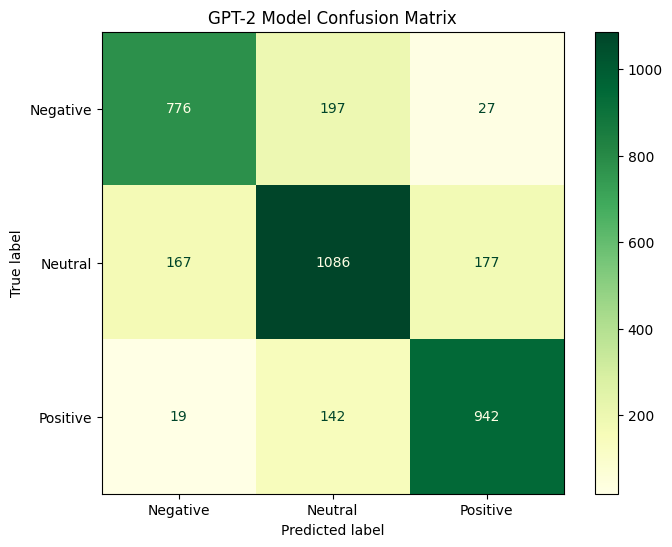

In [29]:
# Plot confusion matrix
class_names = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize = (8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
disp.plot(cmap = "YlGn", ax = ax)
plt.title("GPT-2 Model Confusion Matrix")
plt.savefig(FIGURES_DIR / "gpt2-model-confusion-matrix.png", bbox_inches = "tight")

In [30]:
# Show precision, recall, f1-score per class
class_path = (METRICS_RESULTS_DIR/ "gpt2-classification-report.txt")

report = classification_report(y_true, y_pred, target_names = class_names)

# Print and save
with open(class_path, "w", encoding = "utf-8") as f:
    print("GPT-2 Model Classification Report:\n")
    print(report)

    f.write("GPT-2 Model Classification Report:\n\n")
    f.write(report)

GPT-2 Model Classification Report:

              precision    recall  f1-score   support

    Negative       0.81      0.78      0.79      1000
     Neutral       0.76      0.76      0.76      1430
    Positive       0.82      0.85      0.84      1103

    accuracy                           0.79      3533
   macro avg       0.80      0.80      0.80      3533
weighted avg       0.79      0.79      0.79      3533



The GPT-2 model performs well across all classes, with precision and recall scores generally above 0.75. The positive class shows the highest F1 score at 0.84, indicating strong detection of positive sentiments. Negative and neutral classes also have balanced precision and recall around 0.78 and 0.76, respectively. Overall accuracy is 79%, with consistent macro and weighted averages, confirming balanced performance without bias toward any class.

In [31]:
# Save the best model after training
trainer.save_model(MODELS_DIR / "gpt2" / "gpt2-final-model")
# Save tokenizer
tokenizer.save_pretrained(MODELS_DIR / "gpt2" / "gpt2-final-model")

('/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/models/gpt2/gpt2-final-model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/models/gpt2/gpt2-final-model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/models/gpt2/gpt2-final-model/vocab.json',
 '/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/models/gpt2/gpt2-final-model/merges.txt',
 '/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/models/gpt2/gpt2-final-model/added_tokens.json')

## Model Inference

Use the fine-tuned GPT-2 model to predict sentiment labels on new tweet data. This step applies the trained model to unseen texts for practical sentiment classification.

In [32]:
# Load the trained model and the tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODELS_DIR / "gpt2" / "gpt2-final-model")
tokenizer = GPT2Tokenizer.from_pretrained(MODELS_DIR / "gpt2" / "gpt2-final-model")

In [33]:
# Create a classification pipeline
device_num = 0 if torch.cuda.is_available() else -1
pipeline = TextClassificationPipeline(model = model, tokenizer = tokenizer, device = device_num)

Device set to use cuda:0


In [34]:
# Sample test texts
input_texts = [
    "The food was hot and delicious.",
    "Just landed my dream job! Can’t believe it 🙌 So excited for what’s ahead!",
    "The staff of the restaurant were not friendly.",
    "Ugh, my flight got delayed again. This is getting ridiculous.",
    "Heading to the grocery store, then back to work. Just a regular Thursday.",
    "I love how everything always breaks when I need it most. 🙃",
    "My package arrived two days early! Thanks for the great service!",
    "What a waste of time. I could’ve been doing literally anything else.",
    "It's been a day. Not good, not bad. Just... a day.",
    "Coffee hit just right this morning ☕️🔥",
    "Lost all my work because of a crash. Fantastic.",
    "Can’t wait for the weekend! Plans are finally coming together.",
    "This place has really gone downhill. Used to love it here.",
    "Weather’s perfect today—sunny with a light breeze. Love it.",
    "Guess who forgot their umbrella again? This guy.",
    "Wow. They really nailed it this time. Super impressed!",
    "The instructions were unclear, and now I’m stuck.",
    "Just finished my workout. Feeling strong 💪",
    "Honestly, I don’t even care anymore.",
    "Nothing beats a quiet evening with a good book.",
    "Cool. Another update that broke everything.",
    "Met some amazing people today—grateful for the experience.",
    "No big deal, just spilled coffee on my laptop. Send help.",
    "Finally got around to cleaning my room. Feels good!",
    "So many bugs in this app, it should come with a net.",
    "Thanks for the quick response—really appreciated.",
    "Forgot how good this song is. Instant mood booster.",
    "Waiting in line for 30 minutes just to be told it's closed.",
    "Dinner with family tonight. Looking forward to it.",
    "Hilarious. My alarm didn’t go off *again.*",
]

In [35]:
predictions_path = (PREDICTIONS_DIR / "predictions_output.txt")

# Map model labels to human-readable labels
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Write top predictions only
with open(predictions_path, "w", encoding = "utf-8") as f:

    def write_and_print(text=""):
        print(text)
        f.write(text + "\n")

    write_and_print("-" * 60)
    write_and_print("Tweet Sentiment Classification Inference")
    write_and_print("-" * 60)

    for i, text in enumerate(input_texts, 1):
        # Run prediction
        raw_preds = pipeline(text, return_all_scores=True)[0]

        # Get top prediction
        top_pred = max(raw_preds, key=lambda x: x["score"])
        top_label = label_map[top_pred["label"]]
        confidence = top_pred["score"]

        # Output result
        write_and_print(f"\nInput Text: {text}")
        write_and_print(f"Predicted Sentiment: {top_label} (Confidence: {confidence:.4f})")

    write_and_print("\n" + "-" * 60)
    write_and_print("Inference Complete. Top predictions saved to file.")
    write_and_print("-" * 60)

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


------------------------------------------------------------
Tweet Sentiment Classification Inference
------------------------------------------------------------

Input Text: The food was hot and delicious.
Predicted Sentiment: Positive (Confidence: 0.9993)

Input Text: Just landed my dream job! Can’t believe it 🙌 So excited for what’s ahead!
Predicted Sentiment: Positive (Confidence: 0.9981)

Input Text: The staff of the restaurant were not friendly.
Predicted Sentiment: Negative (Confidence: 0.9967)

Input Text: Ugh, my flight got delayed again. This is getting ridiculous.
Predicted Sentiment: Negative (Confidence: 0.9995)

Input Text: Heading to the grocery store, then back to work. Just a regular Thursday.
Predicted Sentiment: Neutral (Confidence: 0.9957)

Input Text: I love how everything always breaks when I need it most. 🙃
Predicted Sentiment: Positive (Confidence: 0.9953)

Input Text: My package arrived two days early! Thanks for the great service!
Predicted Sentiment: Positiv

The fine-tuned GPT-2 model was used to predict sentiment labels on a variety of new tweet examples. Each input tweet is classified as Positive, Negative, or Neutral, along with a confidence score indicating prediction certainty.

Sample predictions demonstrate the model’s ability to capture sentiment nuances, accurately identifying emotions in both straightforward and subtle contexts. Confidence scores generally align well with expected sentiment, though some ambiguous cases show lower confidence, highlighting areas for potential improvement.